# Self-supervised eyes classification

## Motivation

Image classification is a well-known pattern recognition and computer vision problem, which imply assigning an image to one of the pre-defined classes. Multiple supervised approaches are used in order to solve this problem. In that case, a model is trained with image-label pairs. Widely used approaches in image processing are based on convolutional neural networks (CNN), which are able to effectively solve the problems of image classification and recognition [(Krizhevsky et al.)](#Krizhevsky). However, what happens if the labels are not available during training? This situation is closer to real life, e.g. there are a lot of unlabelled data on the Web, medical data etc. In this case, we have to deal with the problem of clustering based on inherited image similarities. Semi-supervised and unsupervised approaches have been introduced in order to detect these similarities [(Chapelle et al.)](#Chapelle). This is a significant milestone in machine and deep learning since these approaches help to find important semantic features in unstructured data and generate more data [(Olaode et al.)](#Olaode).

Recent advances in unsupervised approaches based on autoencoders and generative adversarial networks (GANs) [(Goodfellow et al.)](#Goodfellow) motivate us to leverage them to the problem of unsupervised image classification. However, while the limitation of traditional autoencoders is a discrete latent space that leads to the poor reconstruction quality, the disadvantage of GANs is a difficult training procedure, which tends to be unstable.  

Variational autoencoder [(Kingma et al., Doersch et al.)](#Kingma) is a trade-off between these two approaches. On the one hand, its latent space is continuous, which contributes to the higher reconstruction quality. On the other hand, the training of VAE is more stable than GANs. Therefore, in this project, we apply an approach based on VAE. We use it for the binary classification of closed and open eyes, but this approach can be extended to multiclass problems with other types of unlabeled data.  

## Problem

In this project, we classify open and closed human eyes presented in a dataset. The dataset includes 4000 images of size 24x24 without labels. Thus, we solve the binary classification problem with unlabelled data. The goals of this project:
1. Research the problem of the limited size of the annotated datasets.
2. Implement an approach based on VAE to classify images with eyes where the final *score $\in$ [0,1]*, i.e. 0.0 - closed, 1.0 - open.
3. Evaluate classification results.


## Approach

The approach consists of two stages. 

### [**Stage 1:**](#Stage1) Unsupervised trainig with VAE 


In the first stage, we train VAE in an unsupervised manner, i.e. VAE accepts an image as an input and tries to reconstruct this image minimizing a loss function. Let's look at the general VAE architecture:


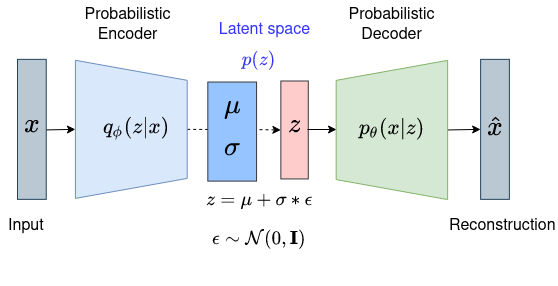

In [15]:
#Import library
from IPython.display import Image # Load image from local storage
Image(filename = "./images/vae.png", width = 500, height = 400)

**Figure 1:** General VAE architecture.

VAE consists of an encoder (or a recognition model) and a decoder (or a generative model). In our case, $x$ is a distribution of input images. The encoder outputs construct a Gaussian distribution with the mean $\mu$ and the standard deviation $\sigma$. VAE provides a continuous latent space due to KL divergence, which matches a prior normal distribution $p (z)$ and a predicted encoder distribution (an approximate posterior) $p_{\theta}(x|z)$. The output of VAE corresponds to the posterior distribution of reconstructed images $\hat x$ [(Doersch et al.)](#Doersch).

#### Re-parametrization trick

An optimization process requires a deterministic model rather than stochastic w.r.t. learnable parameters. Therefore, we have to re-parametrize the encoder outputs. For *reparametrization trick* we define normally-distributed auxiliary random variables $\epsilon\sim\mathcal{N}(0, \textbf{I})$ and perform sampling of latent variables $z\sim\mathcal{N}(\mu, \sigma^2 \textbf{I})$  by calculating $z = \mu + \sigma * \epsilon$, where $*$ denotes an element-wise product [(Kingma et al.)](#Kingma). 

**Note:** the encoder returns $\log \sigma^2$ for numerical stability.


#### Loss function

A VAE loss function represents the sum of a reconstruction error and KL divergence. 

 * Generally the *reconstruction error* corresponds to the mean square error (MSE) between a ground truth image and a reconstructed image:

```
loss_reconstruction = F.mse_loss(x_gt, x_pred)

```
where $x_{gt}$ and $x_{pred}$ are the ground truth and predicted images respectively.  

* *KL divergence* is calculated for the Gaussian encoder distribution:

```
kl = (std ** 2 + mu ** 2 - torch.log(std) - 1 / 2).mean()
```
* The total VAE loss:

```
loss = loss_reconstruction + kl
```

We consider the VAE modification, which is called $\beta$-VAE, the difference is in the loss function, where $\beta$ is a hyperparameter that balances latent constraints with reconstruction accuracy ([Higgins et al.](#Higgins)). Thus, the loss function is formulated as follows:

```
loss = loss_reconstruction + beta * kl.
```
Therefore, 

* Encoder loss corresponds to the penalizer term, which pushes the approximate posterior to the prior.
* Decoder loss corresponds to the reconstruction error.
* We use $\beta$ in order to achieve a trade-off between two terms.


### [Stage II:](#Stage2) Supervised training with pre-trained VAE

In the second stage, we use the pre-trained VAE encoder for the supervised training. For this purpose, we manually annotated 100 samples from the dataset. We freeze the encoder and apply a sigmoid activation function to the predicted mean values to enable binary classification with the [binary cross-entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) loss function. We set $cls\_threshold=0.5.$ Thus, if the predicted value < 0.5, then the predicted label is "CLOSED", otherwise, "OPEN". 

### Metrics

* Receiver Operating Characteristic (ROC curve) ([Tom et al.](#Tom))

* EER: Equal Error Rate (False Positive Rate = False Negative Rate, smaller is better) 

    - $FPR = \frac{FP}{FP+TN}$ 
    - $FNR = \frac{FN}{FN+TP}$


* Accuracy = $\frac{TP+TN}{TP+FP+TN+FN}$

## Data exploration

First, of all we want to visualize some examples from the dataset.

In [16]:
import os
import random
import matplotlib.pyplot as plt
import utils.data_loader as utils
data_dir = os.path.join('dataset', 'EyesDataset.zip')
labeled_data_dir = os.path.join('dataset', 'targets.json')

In [17]:
image_list, image_path = utils.load_archive(labeled_data_dir, data_dir, exclude_ann=True)

Let's plot some random examples from the dataset.

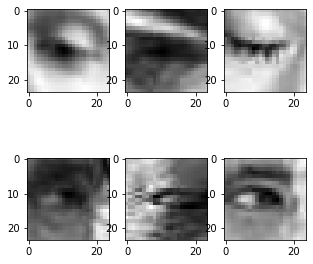

In [18]:
random_list = random.sample(range(0, len(image_list)), 6)
fig, axs = plt.subplots(2, 3, figsize=(5, 5))
axs = axs.flatten()
for i, ax in enumerate(axs):
    sample_i = random_list[i]
    ax.imshow(image_list[sample_i], cmap='gray')
    sample_i += 1

**Figure 2:** Images from the dataset

## Stage I: Unsupervised trainig with $\beta$-VAE
<a id='Stage1'></a>

In the 1st stage, we train $\beta$-VAE with unlabelled data. 

**Note:** we exclude 100 manually annotated images from this stage in order to ensure that there is no influence on the final classification results when we train the classifier and the trained model generalizes well.   

### Some results

We train VAE with $batch\_size = \{64, 512\}$ and $\beta = \{0.1, 0.01, 0.001\}$ for $latent\_size = 50$.

<!-- <figure>
<div align="center">
    <img src="./images/loss_vae_batch64.png" alt="Drawing" style="width: 700px;"/>
    <figcaption>Figure 1: $batch\_size = 64.$ The results correspond to $\beta = 0.1, 0.01, 0.001$  respectively.</figcaption>
    <img src="./images/loss_vae_batch128.png" alt="Drawing" style="width: 700px;"/>
    <figcaption>Figure 2:  $batch\_size = 128.$ The results correspond to $\beta = 0.1, 0.01, 0.001$  respectively.</figcaption>
</div>
    
</figure> -->



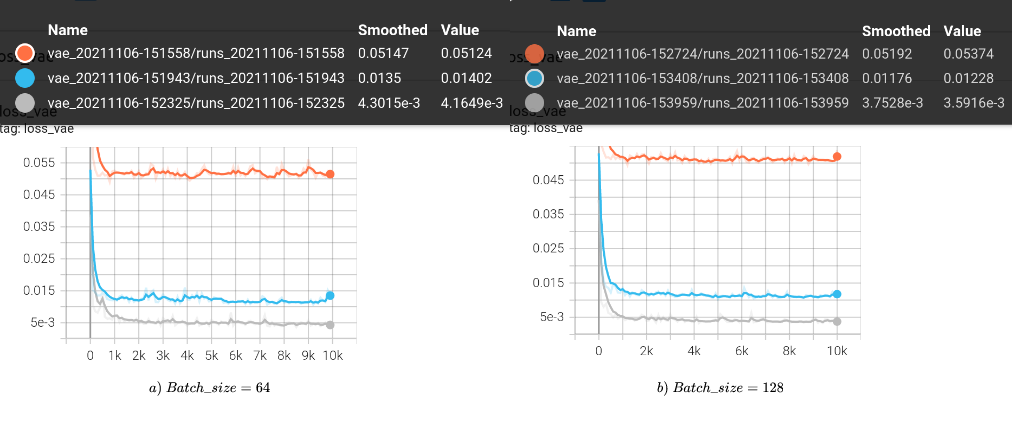

In [19]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "./images/loss_vae_64_128.png", width = 800, height = 400)

<center><b>Figure 3:</b> Validation VAE loss values corresponding to $\beta = 0.1, 0.01, 0.001$  from top to bottom respectively.</center>

The plots above demonstrate that the models with $\beta=0.001$ are characterized by the lowest VAE loss values. Therefore, they achieve a more effective trade-off between reconstruction loss and latent space regularization. Now let's look at some reconstructions from these models after 10000 iterations.

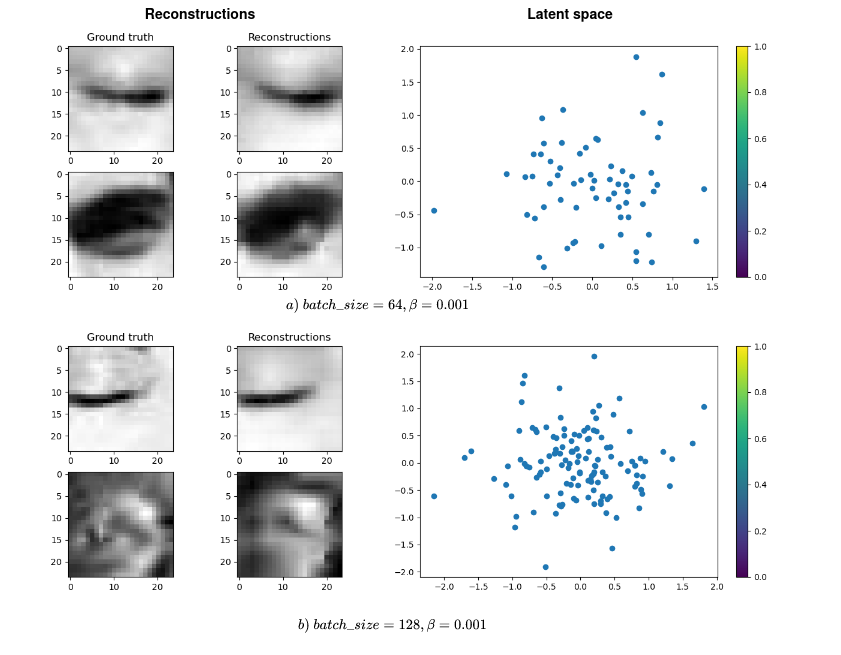

In [20]:
Image(filename = "./images/vae_recon.png", width = 600, height = 500)

**Figure 4:** Reconstructions and latent space for different models

We can notice that the reconstructed images are more smooth than the original. It can be explained by the lower dimension of the latent space, where some features of the ground truth are lost. 

We also visualise two components of the latent space of VAE. A smaller batch size provides a sparser latent space. We can assume that in this case there is a lower chance that samples collide, which may lead to degradation of the reconstruction quality. 

**Note:** Since we do not have labelled data, we are not able to look at how the data are clusterized in the latent space.

Our goal is to use VAE for dimensionality reduction. However, we need to choose an appropriate dimension of the latent space. Let's look at the results for $latent\_size=\{25, 50,100\}$.

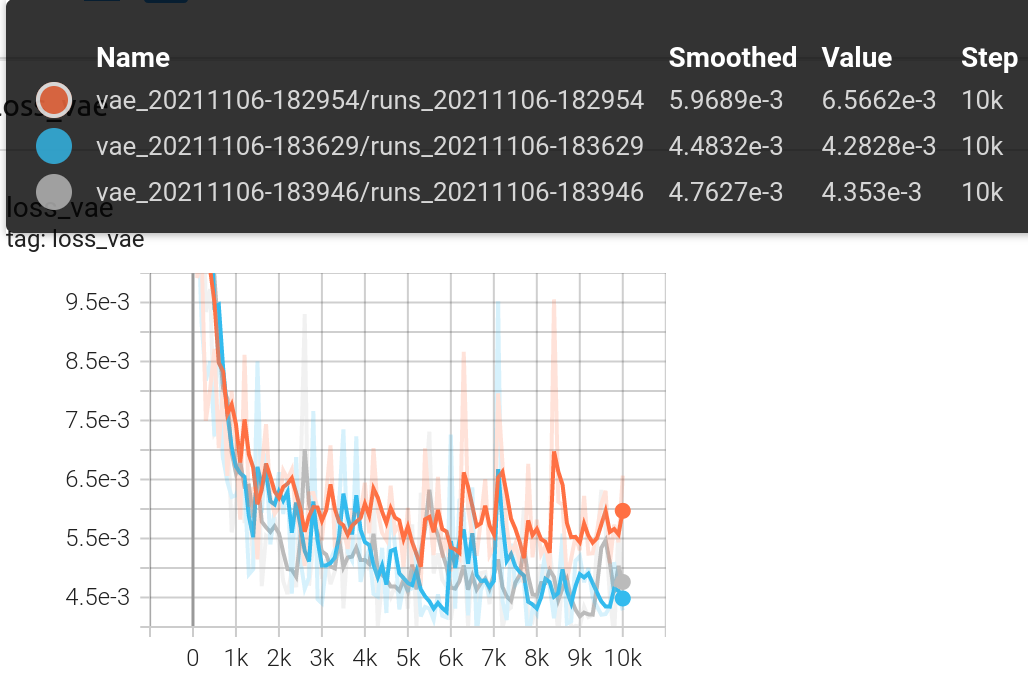

In [21]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "./images/latent_dim.png", width = 500, height = 500)

<b>Figure 5:</b>  $batch\_size = 64, \beta = 0.001$. The results correspond to $latent\_size=\{25, 50,100\}$ from top to bottom.

Since the VAE loss is lower for $latent\_size=\{50,100\}$ we choose these models for the 2nd stage.

## Stage II: Supervised training of classifier with pre-trained VAE encoder
<a id='Stage2'></a>

Now we use the pre-trained VAE encoder model from Stage I. 

First, we want to examine whether it is possible to train the classifier with the small annotated dataset. For this purpose, we manually annotated 100 images. You can find the JSON file [here](./dataset/targets.json). It should be located in the dataset folder.   

### Some results

We train classifier with different splits of annotated data and different number of samples. We use the pre-trained VAE encoder, which has been trained with $batch\_size = 64, \beta = 0.001$ and $latent\_size=50$. We consider the following data splits in training and validation sets: $\{20:20, 30:30, 40:40, 50:50\}$ and set the smaller $learning\_rate=0.001$.

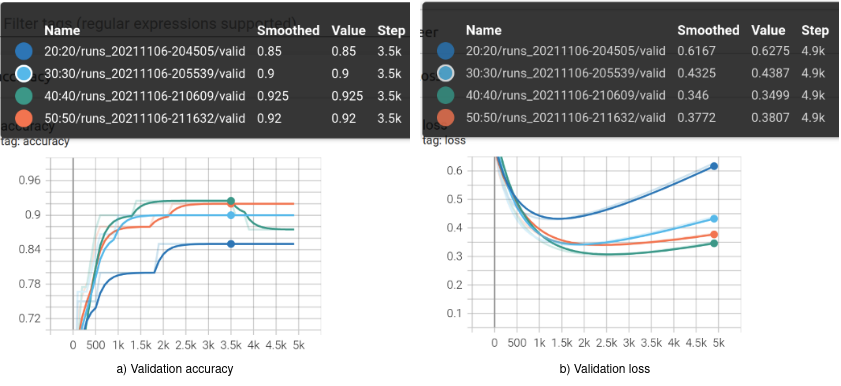

In [22]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "./images/cls_val_acc_loss.png", width = 700, height = 300)

**Figure 6:** Validation accuracy and loss for different splits 

Now we plot Equal Error Rate for the validation sets. We expect $EER <= 0.05$

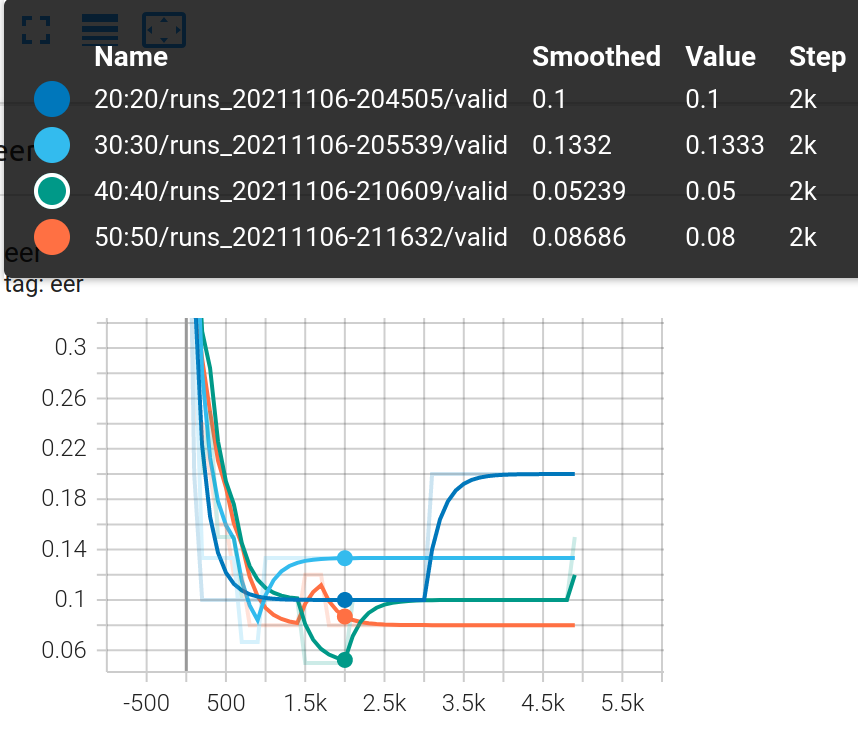

In [23]:
Image(filename = "./images/eer.png", width = 300, height = 300)

**Figure 7:** Equal Error Rate (EER) for validation sets

From the plots above we can conclude that the model corresponded to the split $\{40:40\}$ is characterized by the smallest validation loss and the lowest EER in comparison to other models. Let's look at more evaluation plots for this model. 

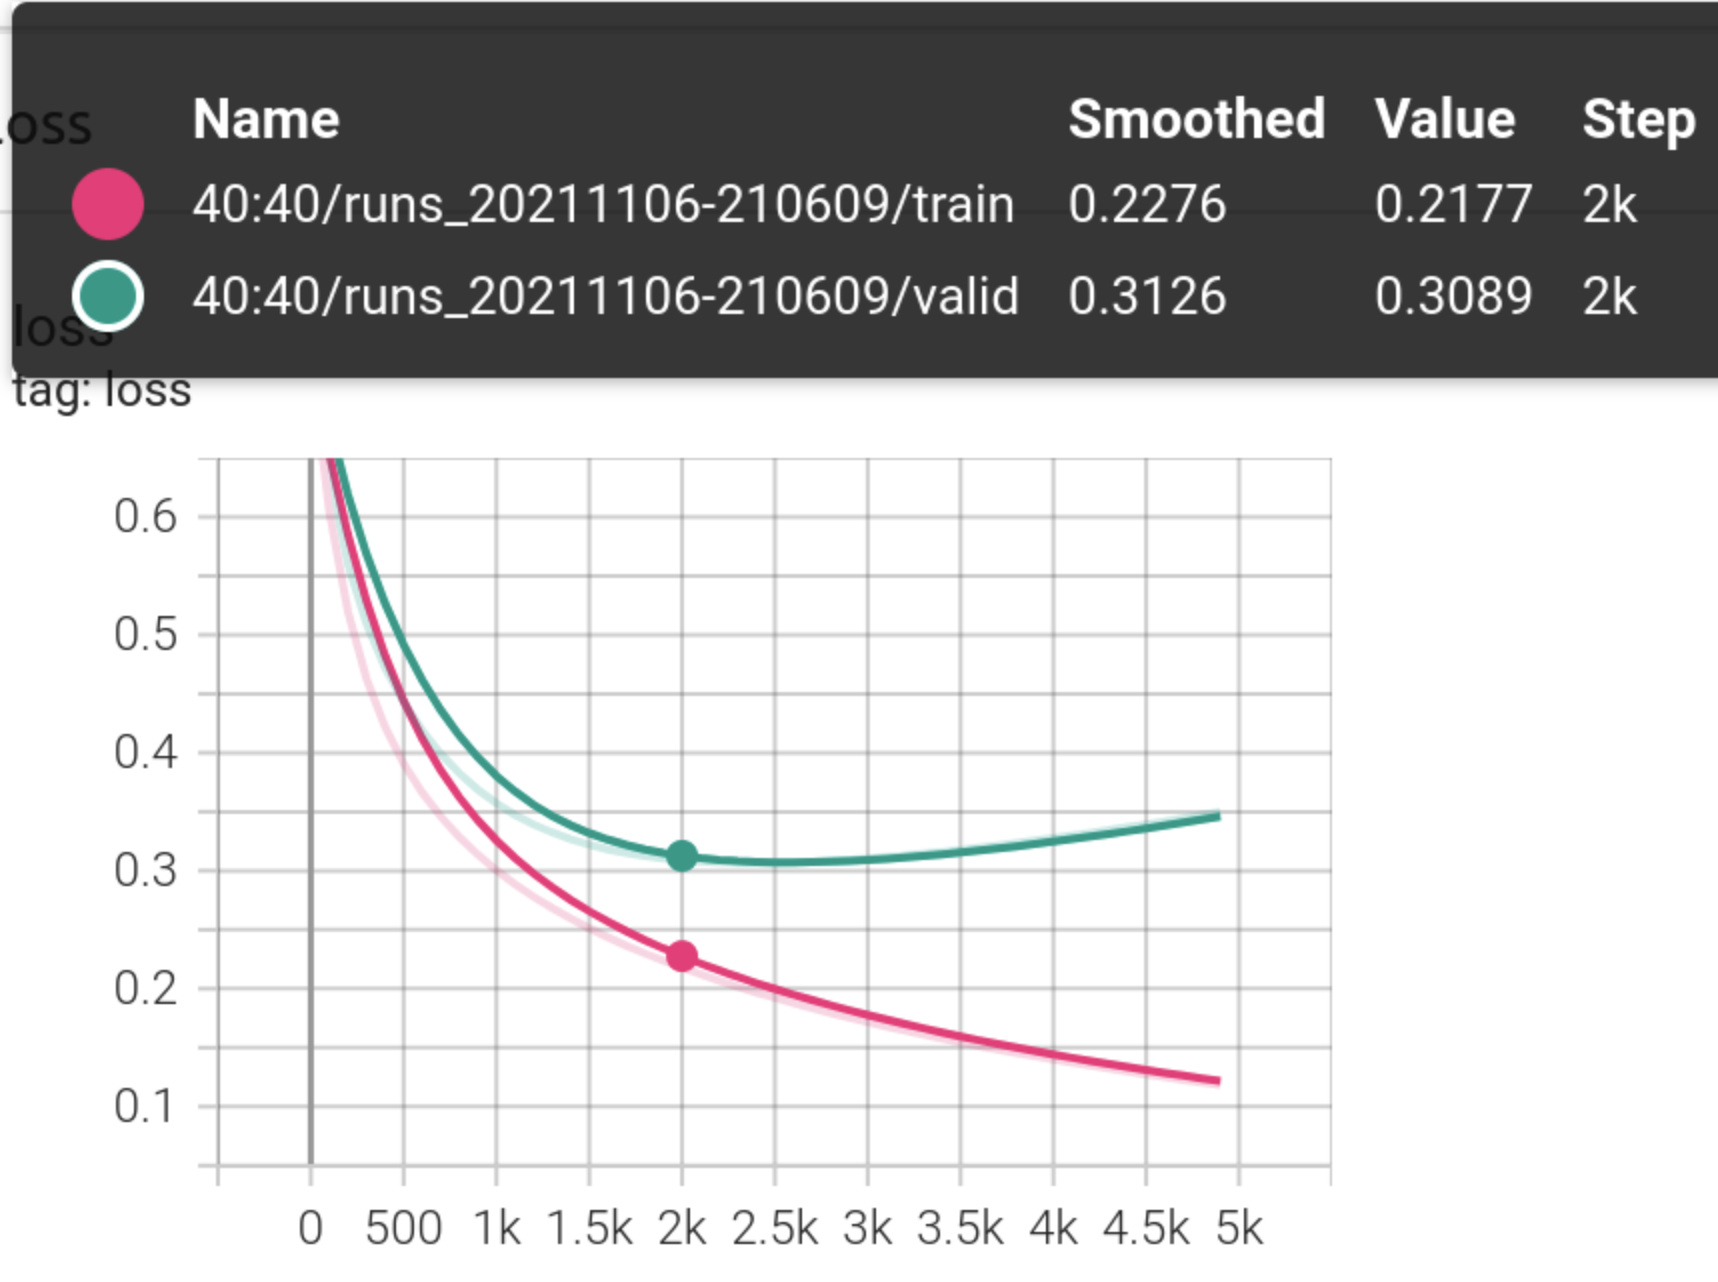

In [24]:
Image(filename = "./images/cls_loss40_40.png", width = 300, height = 300)

**Figure 8:** Training (pink) and validation (green) loss values for the model $batch\_size = 64, \beta = 0.001$ and data split $\{40:40\}$

We can see that the model tends to be overfitted after ~2000 iterations. That means the variance is constantly increasing while the bias becomes lower. Therefore, we use the model, which corresponds to the timestamp ~1500-2000. 

**Model metric values:** accuracy 92.5%, EER=0.05. Just with 40 training samples for training!

In order to demonstrate the meaning of EER, we plot Receiver Operating Characteristic (ROC). We see that EER represent a trade-off between False Positive Rate (FPR) and True Positive Rate (TPR). Moreover, the higher the area under the curve (AUC) the higher model performance.

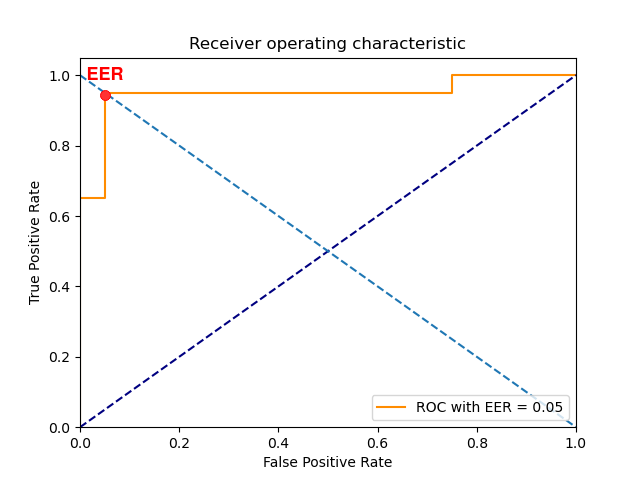

In [25]:
Image(filename = "./images/ROC.png", width = 400, height = 300)

**Figure 9:** ROC and EER for the classifier

Now we can plot some predictions on the validation set. They are saved during training.

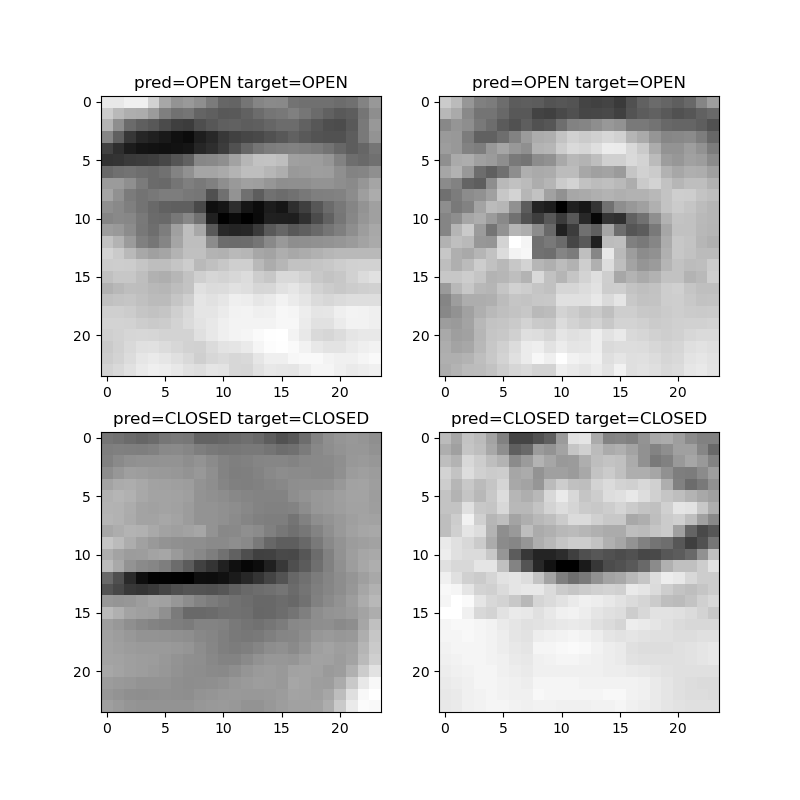

In [26]:
Image(filename = "./images/predictions.png", width = 400, height = 300)

**Figure 10:** Examples with predictions

## Inference

Now let's look at some predictions from the classifier. We can make some predictions for images from the dataset used in Stage I.

### Some examples

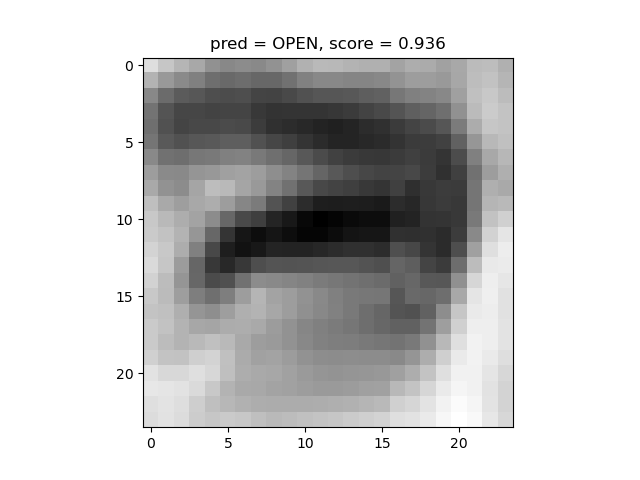

In [27]:
#Import library
from IPython.display import Image# Load image from local storage
Image(filename = "./images/test1.png", width = 300, height = 300)


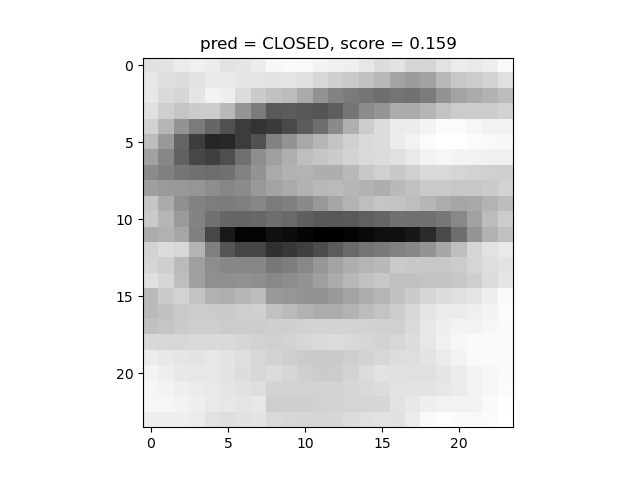

In [28]:
Image(filename = "./images/test2.png", width = 300, height = 300)

We want to visualize some predictions for difficult cases. For this purpose, we took some images from a similar dataset [Closed Eyes In The Wild (CEW) ](http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html), in which labels are available [(Song et al.)](#Song). Moreover, we can interpret the results scores as a measure of model confidence. Then closer the scores to 0.0 or 1.0 are then the model is more confident in its predictions, negative or positive respectively. We can see that for these cases the model is quite confident. 

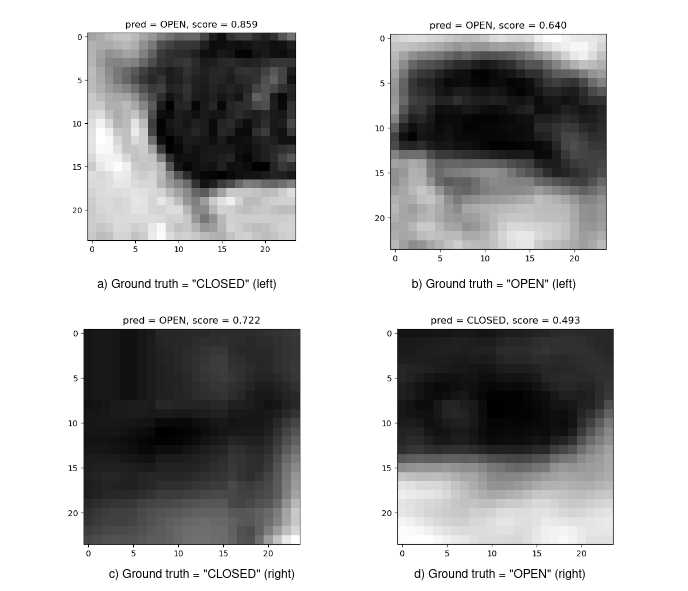

In [29]:
Image(filename = "./images/test_difficult_cases.png", width = 500, height = 300)

**Figure 11:** Difficult cases

We can see that the model predictions are mostly wrong for examples above. Moreover, the model is less certain in its predictions.  We should note, that we annotated data manually and selected only the images where we were absolutely sure about the correct answer. That means the similar behaviour of our model, which works well for more obvious images, otherwise may give wrong predictions.

## Experiments

### Experiment 1: More data splits with the pre-trained VAE

In this experiment we consider more data splits for annotated data, i.e. $\{80:20, 70:30, 60:40, 50:10, 40:10, 40:20, 40:30\}$, where each para corresponds to the split $\{training: validation\}$.

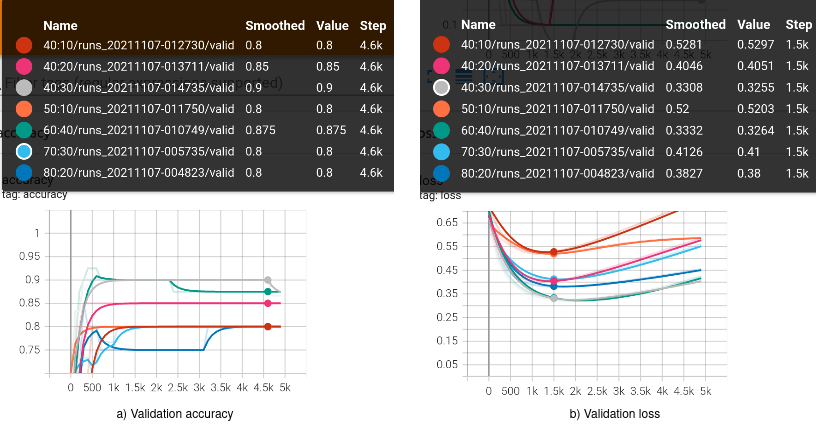

In [30]:
from IPython.display import Image# Load image from local storage
Image(filename = "./images/exp1_splits.png", width = 700, height = 300)

**Figure 12:** Validation accuracy and loss values for different data splits

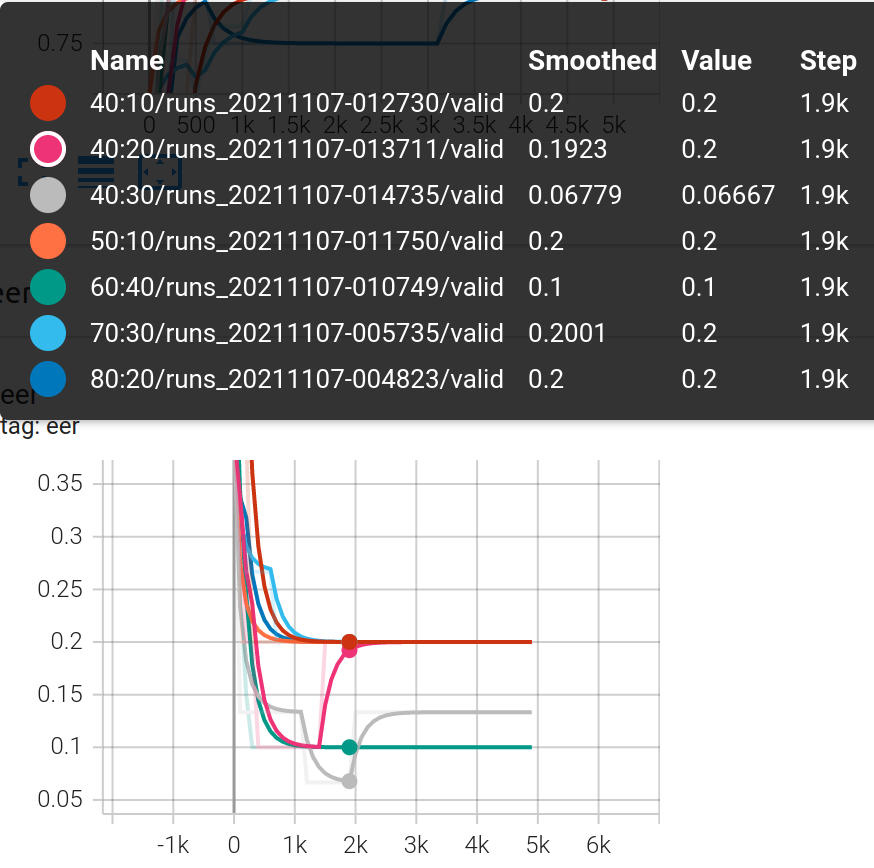

In [31]:
Image(filename = "./images/exp1_splits_eer.png", width = 400, height = 300)

**Figure 13:** EER values for different data splits

In this case we achieve the smallest $EER = ~0.067$ with the split $\{40:30\}$. 

We also apply longer training with the pretrained VAE-encoder for some data splits.

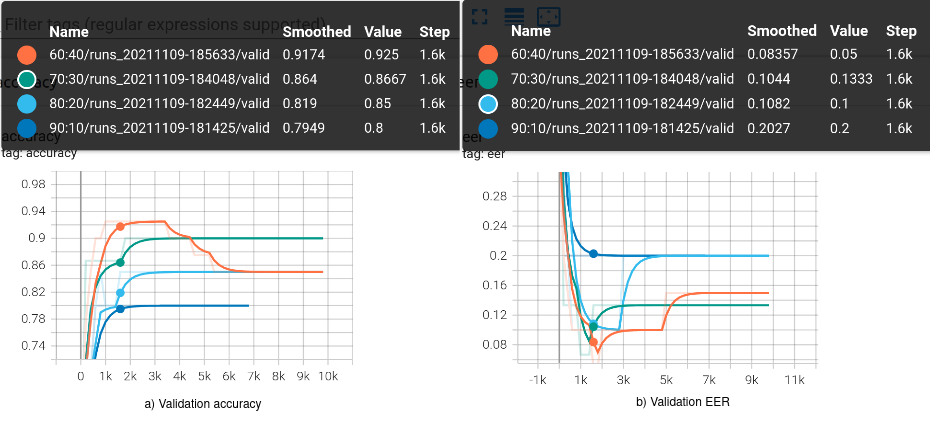

In [32]:
from IPython.display import Image# Load image from local storage
Image(filename = "./images/exp3_acc_eer.png", width = 700, height = 300)

**Figure 14:** Validation accuracy and $EER$ for training with data transformation

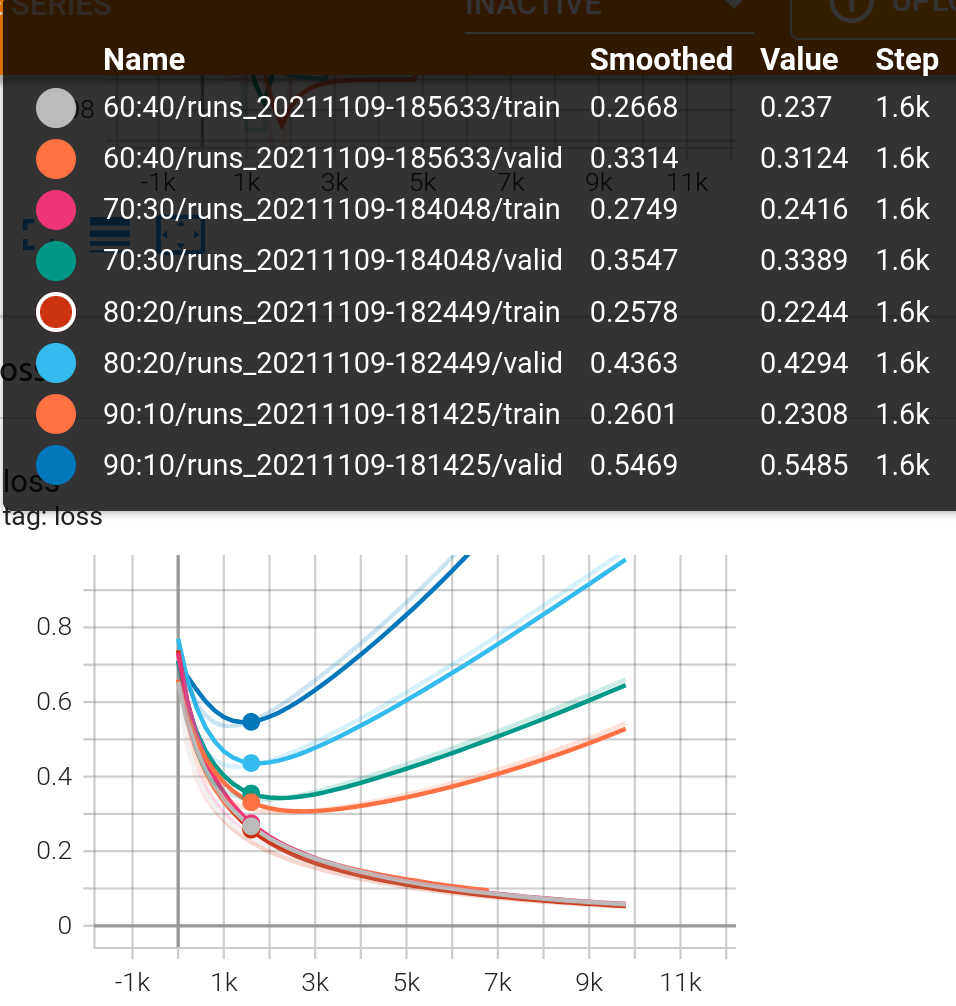

In [33]:
from IPython.display import Image# Load image from local storage
Image(filename = "./images/exp3_loss.png", width =300, height = 300)

**Figure 15:** Validation loss for training with data transformation

In this case, the highest accuracy $92.5\%$ and the lowest $EER=0.05$ correspond to the split $\{60:40\}$, which are close to our previous results with the split  $\{40:40\}$.

### Experiment 2: Train classifier from scratch 

In this experiment, we perform supervised training of the classifier without the pre-trained VAE encoder with different data splits. Since the number of annotated images is quite small the models suffer from overfitting. Figures below demonstrate some training results for models with $\{trainig: validation\}$ splits $\{40:40, 50:50, 70:30\}$

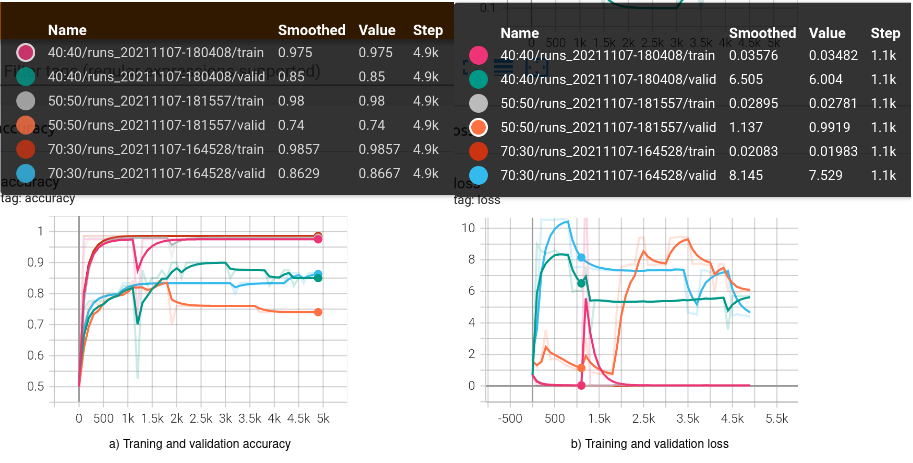

In [34]:
Image(filename = "./images/exp2_overfitting.png", width = 700, height = 300)

**Figure 16:** Accuracy and loss values for different splits for training without pre-trained encoder

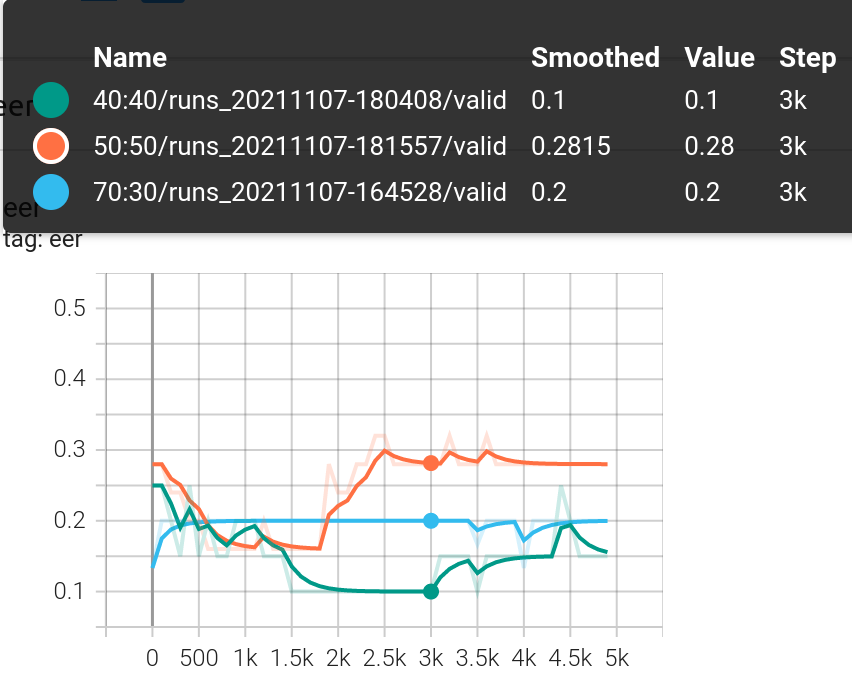

In [35]:
Image(filename = "./images/exp2_eer.png", width = 400, height = 300)

**Figure 17:** EER values for different splits for training without pre-trained encoder

We can see that the overfitting happens after some training iterations, such that the validation loss values are significantly higher than the training loss values. At the same time, we can observe relatively high accuracy, e.g. 86,67% for the split 70:30. We may conclude that the reason for that is the similar data distributions of the training and validation datasets. In the situation when the model is overfitted during training it just memorizes data distribution and shows high performance for similar distributions. However, it does not guarantee that the model generalizes well for testing data, whose distribution may differ. 

## Conclusion

In this project, we examined the image classification problem with the unlabelled dataset. Our experiments demonstrate the following:

1. The supervised training with a limited annotated dataset is challenging since the model tends to memorize the training samples quickly, which leads to an overfitting problem. At the same time, the model can show an appropriate accuracy (e.g. 86,67% for data split 70:30) for the validation dataset since the distributions of training and validation data are very similar.  
2. The semi-supervised training with a few manually annotated data allows us to overcome the abovementioned problem. For this purpose, we use 2-stage training. In the first stage, we train VAE in an unsupervised manner to train VAE to reconstruct images. Thus, the VAE encoder learns how to reduce image dimensions effectively. In the 2nd stage, we use a pre-trained encoder and add a sigmoid classifier with $cls\_threshold = 0.5$ to make predictions. This training allowed us to avoid fast overfitting and increase the accuracy to 92.5% and decrease $EER$ to 0.05% from accuracy 85% and $EER=0.1$, which correspond to the same data split $\{40:40\}$ from the training without pre-trained encoder.
3. A challenge of the semi-supervised procedure is an appropriate data split. Our experiments show that the model performance (based on accuracy and $EER$) significantly depends on it. Therefore, the different data splits should be examined for training. 
4. We can interpret the predicted scores as a measure of model confidence. Then closer the scores to 0.0 or 1.0 are then the model is more confident in its predictions, negative or positive respectively. We demonstrated that the model is more confident for obvious images and less for images, in which we are not sure as well.  We can assume the following reason for that. We annotated data manually and selected only the images where we were absolutely confident about the correct answer. That means the similar behaviour of our model, which works well for more obvious images, otherwise may give wrong predictions.

## Summary:

The resulted model has been trained in 2 stages: 
1. Unsupervised VAE for image reconstruction.
2. Supervised classification with the manually annotated data and data split {40:40}.

The results: accuracy 92.5%, $EER=0.05$. Just with 40 training samples!


## Bonus: Let's run inference!

INFO:root:Used device: cuda:0
INFO:root:Loading model: /home/maria/Study/VisionLabs/eyes-classification/output/cls/cls_20211106-210609/cls_1500_20211106-210609.pth
INFO:root:Prediction: 0.537104
INFO:root:Used device: cuda:0
INFO:root:Loading model: /home/maria/Study/VisionLabs/eyes-classification/output/cls/cls_20211106-210609/cls_1500_20211106-210609.pth
INFO:root:Prediction: 0.216792


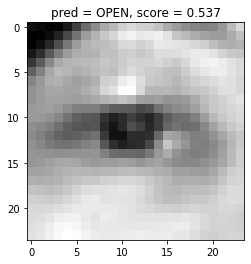

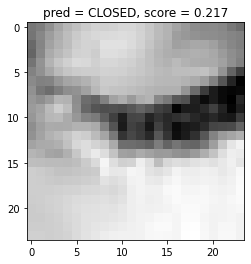

In [75]:
%run  inference.py -cls_path eyes-classification/output/cls/cls_20211106-210609/cls_1500_20211106-210609.pth -im_path images/inf_test1.jpg
%run  inference.py -cls_path eyes-classification/output/cls/cls_20211106-210609/cls_1500_20211106-210609.pth -im_path images/inf_test2.jpg

You can also find this result in the directory `output/inference/inference_<timestamp>`

## References

1. Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM, 2017.  <a id='Krizhevsky'></a>

2. Olaode, Abass & Naghdy, Golshah & Todd, Catherine. Unsupervised Classification of Images: A Review. International Journal of Image Processing, 2014. <a id='Olaode'></a>

3. Chapelle, O.; Schölkopf, B. & Zien, A., ed. (2006), Semi-Supervised Learning , The MIT Press. <a id='Chapelle'></a>

4. Goodfellow, Ian & Pouget-Abadie, Jean & Mirza et al. Y. Generative Adversarial Networks. Advances in Neural Information Processing Systems, 2014.<a id='Goodfellow'></a>

5. Kingma, Diederik P. and Max Welling. “An Introduction to Variational Autoencoders.” Found. Trends Mach. Learn. 2019. <a id='Kingma'></a>

6. Doersch, Carl. (2016). Tutorial on Variational Autoencoders. <a id='Doersch'></a>

7. Higgins, Irina et al. “Beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework.” ICLR,  2017.  <a id='Higgins'></a>

8. Fawcett, Tom (2006). "An Introduction to ROC Analysis". Pattern Recognition Letters. 27 (8): 861–874. doi:10.1016/j.patrec.2005.10.010. <a id='Tom'></a>

9. F.Song, X.Tan, X.Liu and S.Chen, Eyes Closeness Detection from Still Images with Multi-scale Histograms of Principal Oriented Gradients, Pattern Recognition, 2014.<a id='Song'></a>

